# Introduction
In this tutorial, you will learn how to read L3 TRMM binary data into Python.  TRMM is the  [Tropical Rainfall Measuring Mission](https://trmm.gsfc.nasa.gov/).  As an aside, it is recommended to use netCDF-4 formatted data for Python instead of binary files.  However, this tutorial will take you through the process of extracting data from the binary files.

# Import Dependencies
Let's import all the libraries we need. This needs to be done before any of the other cells can be run. These libraries were installed in the docker container you are using, so we will not need to worry about installing anything. Simply running the following cell takes care of all of the dependencies.

In [1]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import netCDF4
import os

## Obtaining Data

We first need to obtain some TRMM L3 data. <br> <br> 
The TRMM L3 data repository is located here: ftp://trmmopen.gsfc.nasa.gov/pub/merged/3B42RT/ <br> 
<br>
After this page fully loads (this might take a moment), you can enter a directory for a given year. From here, you can enter into a directory for each month.  For the purpose of this tutorial, we will use the second dataset for the year 2010. 
<br>
<br>
In this case, the full link to this dataset is: ftp://trmmopen.gsfc.nasa.gov/pub/merged/3B42RT/2010/01/3B42RT.2010010103.7R2.bin.gz
<br>
<br>
If you go to the above website, it will automatically download this file to your local machine (not part of this tutorial).
We will use the wget command to download this file to our local directory. Run the following command in your terminal (for information on how to use `wget`, see the `ACOS_DATA_HANDLING` tutorial).

> `cd /home/condauser/tutorials/notebooks/READING_BIN_TUTORIAL`

> `wget "ftp://trmmopen.gsfc.nasa.gov/pub/merged/3B42RT/2010/01/3B42RT.2010010103.7R2.bin.gz"`

Now, there is a file (`3B42RT.2010010103.7R2.bin.gz`) in your local directory.  You can see this by running the following command:

> `ls`

Let's unpack this to the bin file by using the following commands in your terminal.

> `gunzip 3B42RT.2010010103.7R2.bin.gz`

These commands unzip the binary file. Now, we are ready to read the file into python. Run one more command to see the binary file in your local directory:

> `ls`

## Reading in the file to Python
Open the binary file using the "rb" as the I/O mode. This will ensure that Python understand that this file is binary.  The header length for binary TRMM data is 2880 character.  Let's look at the header for this bin file.

In [2]:
binAddress = '/home/condauser/tutorials/notebooks/READING_BIN_TUTORIAL/3B42RT.2010010103.7R2.bin'
binFile = open(binAddress, 'rb')

binData = binFile.read()
headerLength = 2880

header = [i for i in binData[0:headerLength].decode('utf-8').replace(',', ' ').split(' ') if i != ""]

header

['algorithm_ID=3B42RT',
 'algorithm_version=07.00',
 'granule_ID=3B42RT.2010010103.7R2.bin',
 'header_byte_length=2880',
 'file_byte_length=(char2880)_header+(int2)x1440x480x2_data+(int1)x1440x480_data+(int2)x1440x480_data',
 'nominal_YYYYMMDD=20100101',
 'nominal_HHMMSS=030000',
 'begin_YYYYMMDD=20100101',
 'begin_HHMMSS=013000',
 'end_YYYYMMDD=20100101',
 'end_HHMMSS=043000',
 'creation_date=20121218',
 'west_boundary=0E',
 'east_boundary=360E',
 'north_boundary=60N',
 'south_boundary=60S',
 'origin=northwest',
 'number_of_latitude_bins=480',
 'number_of_longitude_bins=1440',
 'grid=0.25x0.25_deg_lat/lon',
 'first_box_center=59.875N',
 '0.125E',
 'second_box_center=59.875N',
 '0.375E',
 'last_box_center=59.875S',
 '359.875E',
 'number_of_variables=4',
 'variable_name=precipitation',
 'precipitation_error',
 'source',
 'uncal_precipitation',
 'variable_units=mm/hr',
 'mm/hr',
 'source_number',
 'mm/hr',
 'variable_scale=100',
 '100',
 '1',
 '100',
 'variable_type=signed_integer2',
 's

## Header Information
Looking through the header, we can find a great deal of useful information that will be necessary for furthing unpacking the data:

* The number of latitude bins is 480
* The number of longitude bins is 1440
* Latitude bounds: 60S to 60N
* Longitude bounds: 0E to 360E
* Grid resolution: 0.25x0.25 degrees Lat/Lon
* Byte Order = Big Endian

You can also obtain the number of bins by looking at the grid size and the range of coordinates. In this case, the longitude is bound by 0E to 360E.  Latitude is bound by 60S to 60N. Each grid bin is 0.25x0.25 degrees lat/lon.

In [3]:
print(360 / 0.25)
print(120 / 0.25)

1440.0
480.0


* Variable Information:
<pre>
| Names | precipitation   | precipitation_error |        source       | uncal_precipitation |
|-------|-----------------|---------------------|---------------------|---------------------|
| Units |       mm/hr     |        mm/hr        |     source number   |        mm/hr        |
|-------|-----------------|---------------------|---------------------|---------------------|
| Scale |       100       |         100         |           1         |         100         |
|-------|-----------------|---------------------|---------------------|---------------------|
| Type  | signed_integer2 |    signed_integer2  |    signed_integer1  |    signed_integer2  |
|-------|-----------------|---------------------|---------------------|---------------------|
</pre>
* file_byte_length=(char2880)_header+(int2)x1440x480x2_data+(int1)x1440x480_data+(int2)x1440x480_data

We can see that most of the data is of type *signed_integer2* (2 bytes of information).

Now, we can understand the file itself.  The first 2880 bytes are the header. The next 1382400 bytes are the precipitation data (440 x 1440 x 2).  The next 1382400 bytes are the precipitation error data.  The following 691200 bytes are the source data.  The last 1382400 bytes are the uncalibrated precipitation data.  In total, that is 4841280 bytes (or characters). Let's check to make sure that is correct.

In [4]:
len(binData) == 4841280

True

In [5]:
rows = 480
cols = 1440
dataLengthBytes = 2 * rows * cols + headerLength
dataLengthBytes

1385280

## Gathering the Data
Since we read the file as a binary file, we can use the `np.fromstring()` function to import our data. In the header, we saw that the variable type of the precipitation variable was `signed_integer2`, so we can tell our function to read the data from this format by putting in the `np.dtype(">i2")` function.  The `>` in front of `i2` reads the binary file as Big Endian (specified in the header).  We then convert this to a float and rescale our variable by dividing by 100 (as mentioned in the header). Finally, this is now just a big 1-Dimensional array of our data. But it should be gridded by latitude and longitude, as per the header. So we use the `reshape()` procedure to create this grid.

In [6]:
precipBin = np.fromstring(binData[headerLength:dataLengthBytes], np.dtype(">i2"))
precipBin = np.asarray(precipBin, np.dtype("float32"))
precipBin /= 100
precipBin = precipBin.reshape(rows,cols)

## Cleaning the Data
We need to mask all the values where the error flag appears (-31999, as per the header).

In [7]:
precipBinMasked = np.ma.masked_where(precipBin < -300, precipBin)

## Data Statistics
Let's record some basic statistics about our imported data to compare with the `.nc4` version of the same data we have found online.

In [8]:
binMean = precipBinMasked.mean()
binMax = precipBinMasked.max()
binMin = precipBinMasked.min()

## Downloading `.nc4` Data
Now, let's download the `.nc4` version of our dataset to confirm that we have been converting our binary correctly.  The same data in .nc4 is stored at at [this OPeNDAP server](https://disc2.nascom.nasa.gov/opendap/hyrax/). You can:

1. Open the directory: TRMM_RT/
2. Open the directory: TRMM_3B42RT.7/
3. Open the directory: 2010/
4. Open the directory: 001/



For this tutorial, however, we will use `wget`. For more information on the `wget` command, see `ACOS_DATA_HANDLING` notebook. To download this data, run the following command in your terminal:

> `cd /home/condauser/tutorials/notebooks/READING_BIN_TUTORIAL`

Run the following command in your terminal, except replace `<username>` and `<password>` with your Earthdata username and password. **Don't forget to put your username and password in *single quotes*.**

> `wget --user='<username>' --password='<password>' "https://disc2.nascom.nasa.gov/opendap/TRMM_RT/TRMM_3B42RT.7/2010/001/3B42RT.2010010103.7R2.nc4.nc4"`

Run the following command to get rid of your terminal history so that your password remains protected:

> `history -c`

Now, type in the following command to confirm that the .nc4 file was downloaded into your local directory

> `ls`

In [9]:
NC4Address = '/home/condauser/tutorials/notebooks/READING_BIN_TUTORIAL/3B42RT.2010010103.7R2.nc4.nc4'


NC4File = netCDF4.Dataset(NC4Address)

latNC4 = NC4File["lat"][:]
lonNC4 = NC4File["lon"][:]

precipNC4 = NC4File["precipitation"][:]

latsNC4, lonsNC4 = np.meshgrid(latNC4, lonNC4)

NC4Mean = precipNC4.mean()

NC4Min = precipNC4.min()

NC4Max = precipNC4.max()

## Checking the Data is Equal
Let's see if our `.nc4` data is the same as our `.bin` converted data. Since the Data is represented in slightly different ways (more on this later), we cannot simply compare the matrices. We will use sample statistics for a quick confirmation, and we will visually confirm using a plot later in this notebook.

In [10]:
print("Checking Equality.")
if abs(1 - binMean/NC4Mean) < 0.05:
    print("Means equal.")
    
if binMax == NC4Max:
    print("Maxes equal.")
    
if binMin == NC4Min:
    print("Mins equal.")

print("Finished Checking Equality.")

def is_equal(binary_file, nc4_file):
    bfin = open(binary_file, 'rb')
    bdat = bfin.read()
    bhdr = bdat[0:2880].decode('utf-8').strip()
    import netCDF4
    return bhdr in str(netCDF4.Dataset(nc4_file))

is_equal(binAddress, NC4Address)

Checking Equality.
Means equal.
Maxes equal.
Mins equal.
Finished Checking Equality.


True

## Transposing the grd
The precipitation data from the binary file has the following shape.

In [11]:
precipBinMasked.shape

(480, 1440)

You will notice, however, that the number of longitude and latitude bins are 1440 and 480, respectively.  For plotting purposes, we are going to transpose our data in order to match the number of bins.  This is because the mapping package used later on in this tutorials reads data in (longitude, latitude) format.

In [12]:
precipBinMasked = precipBinMasked.T

In [13]:
precipBinMasked.shape

(1440, 480)

## Translating the grid
The data we translated from binary is represented slightly differently than the `.nc4` data we found online. The `.bin` file is plotted from 0$^\circ$ to 360$^\circ$ longitude. The `.nc4` file is plotted from -180$^\circ$ to 180$^\circ$ longitude. To take care of this, we shift our measurements from the binary file over by 180 degrees. Our grid is at increments of 0.25$^\circ$ longitude, so we need to shift our matrix over by 720 indices. We can do this using the `np.roll()` function.

In [14]:
l = np.roll(np.fliplr(precipBinMasked), 720, axis=0)

## Setting up the Plot
Now that our data agrees, we can set up our plot by creating a mesh-grid of our latitude and longitude data.

In [15]:
latStart = -60
latFinish = 60
latStep = 0.25

lonStart = -180
lonFinish = 180
lonStep = 0.25

latBin = np.arange(latStart,latFinish, latStep)
lonBin = np.arange(lonStart, lonFinish, lonStep)

latsBin, lonsBin = np.meshgrid(latBin, lonBin)

## Plotting the Data
Here, we plot the data. For information on how to do this, see the `ACOS_DATA_HANDLING` notebook.

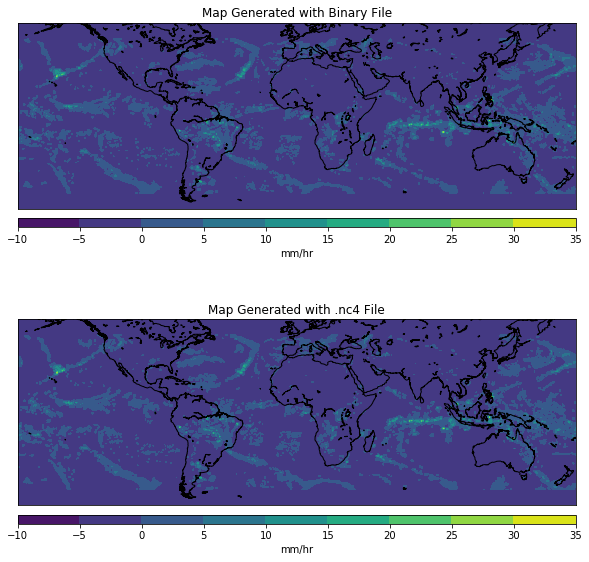

In [16]:
plt.figure(figsize=(10,10))
plt.subplot(211)
b = Basemap(projection='cyl',llcrnrlat=-60,urcrnrlat=60,\
            llcrnrlon=-180,urcrnrlon=180,resolution='l')
b.drawcoastlines()
cs = b.contourf(lonsBin, latsBin, l, latlon=True)
cbar = b.colorbar(cs, location='bottom', pad='5%')
cbar.set_label("mm/hr")
plt.title("Map Generated with Binary File")

plt.subplot(212)
b = Basemap(projection='cyl',llcrnrlat=-60,urcrnrlat=60,\
            llcrnrlon=-180,urcrnrlon=180,resolution='l')
b.drawcoastlines()
cs = b.contourf(lonsNC4, latsNC4, precipNC4.T, latlon=True)
cbar = b.colorbar(cs, location='bottom', pad='5%')
cbar.set_label("mm/hr")
plt.title("Map Generated with .nc4 File")